In [ ]:
import numpy as np
from scipy.optimize import root_scalar
import matplotlib.pyplot as plt

mu = 398600.4418  # km^3/s^2

##########################
# Mark's Equations
##########################

def solve_E_for_r(r, a, e):
    # solve for cosin(e) rearrange r = a(1 - e*cos(E)) to get cos(E), then use arcsin to find E
    # then take the arcsin to find ====> acos((r/a -1)*(1/e))

    def f(E): return a * (1 - e * np.cos(E)) - r
    try:
        sol = root_scalar(f, bracket=[0, np.pi], method='brentq')
        return sol.root if sol.converged else None
    except ValueError:
        return None

def compute_time_fractions_for_orbit(a, e, shell_edges):
    n = np.sqrt(mu / a**3) # mean motion, rad/s, EQUATION 3
    P = 2 * np.pi / n
    times = []

    # EQUATION 1 - r_low and r_high (apogee and perigee)
    r_min = a * (1 - e)
    r_max = a * (1 + e)

    for i in range(len(shell_edges) - 1):
        r_low = shell_edges[i]
        r_high = shell_edges[i + 1]

        # Check if shell overlaps orbit path
        # if the shell is outside the orbit path, skip it
        if r_high < r_min or r_low > r_max:
            times.append(0.0)
            continue

        # Clamp bounds to be inside orbit range
        r1 = max(r_low, r_min)
        r2 = min(r_high, r_max)

        # Solve for eccentric anomaly E1 and E2
        # corresponding to the radii r1 and r2
        E1 = solve_E_for_r(r1, a, e)
        E2 = solve_E_for_r(r2, a, e)

        if E1 is None or E2 is None:
            times.append(0.0)
            continue
        
        # EQUATION 2
        # Convert to mean anomaly
        M1 = E1 - e * np.sin(E1)
        M2 = E2 - e * np.sin(E2)

        # Finally, compute the time spent in the shell
        dt = 2 * (M2 - M1) / n # EQUATON 4
        times.append(dt)

    # Convert time list to array and divide by orbital period
    times = np.array(times)
    times /= P  # <-- now fractions are normalised w.r.t full orbital period, EQUATION 5
    return times


Total time spent in all shells: 0.91


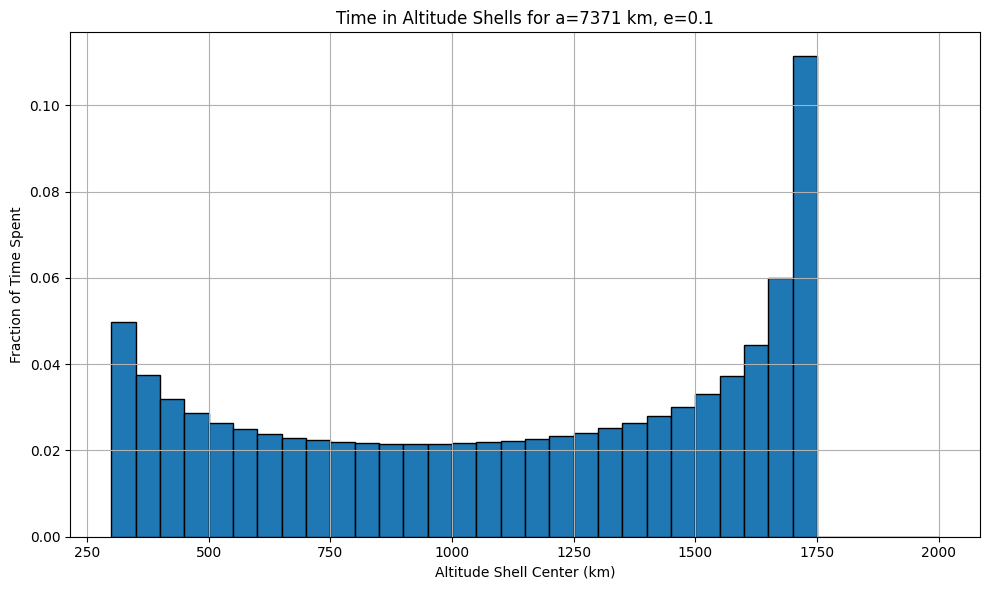

In [7]:
############################
# Test with a simple case
############################

# Test parameters
a_test = 1000 + 6371  # semi-major axis in km
e_test = 0.1   # eccentricity


altitude_shells = np.array([
    300, 350, 400., 450., 500., 550., 600., 650., 700., 750., 800.,
    850., 900., 950., 1000., 1050., 1100., 1150., 1200.,
    1250., 1300., 1350., 1400., 1450., 1500., 1550., 1600.,
    1650., 1700., 1750., 1800., 1850., 1900., 1950., 2000.
])
shell_edges = altitude_shells + 6371 # Convert to sma


# Compute time fractions for test orbit
time_fractions = compute_time_fractions_for_orbit(a_test, e_test, shell_edges)

# sum time_fractions
total_time = np.sum(time_fractions)
print(f"Total time spent in all shells: {total_time:.2f}")

# Compute bin centers for plotting
altitude_bin_centers = (altitude_shells[:-1] + altitude_shells[1:]) / 2

# Plot the results
plt.figure(figsize=(10, 6))
plt.bar(altitude_bin_centers, time_fractions, width=50, align='center', edgecolor='black')
plt.xlabel('Altitude Shell Center (km)')
plt.ylabel('Fraction of Time Spent')
plt.title(f'Time in Altitude Shells for a={a_test} km, e={e_test}')
plt.grid(True)
plt.tight_layout()
plt.show()